In [ ]:
pip install opencv-python pandas seaborn

Note: you may need to restart the kernel to use updated packages.


### Setup

In [1]:
import pandas as pd
from IPython.display import display 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import cv2
import os
import seaborn as sns
from datetime import datetime

### Creating datapaths

In [3]:
path= r"G:\Meu Drive\Meu projeto\csv_analise\top\aversivo\Fiona_d25_teste_snake_1DLC_resnet50_after_surgery_networkNov18shuffle1_300000.csv"
df = pd.read_csv(path, header=[1, 2])

video_path = r"G:\Meu Drive\Meu projeto\csv_analise\top\aversivo\Fiona_d25_teste_snake_1.mp4"
cap = cv2.VideoCapture(video_path) 

stim_timestamps = r"G:\Meu Drive\Meu projeto\csv_analise\top\aversivo\Fiona_d25_teste_snake_stim_ON_OFF_timestamps.csv"
stim_df = pd.read_csv(stim_timestamps, header=[0])

### Dataframe segmentation

##### Stim window

In [4]:
def get_seg_stim(df, stim_on, stim_off, fps=30, i=0):
    start_sec = stim_on[i]
    end_sec = stim_off[i]
        
    start_frame = start_sec * fps
    end_frame = end_sec * fps
        
    segmento = df[(df.index >= start_frame) & (df.index <= end_frame)]

    return segmento

In [5]:
stim1 = get_seg_stim(df, stim_df['stim_ON'], stim_df['stim_OFF'], fps=30, i=0)
stim2 = get_seg_stim(df, stim_df['stim_ON'], stim_df['stim_OFF'], fps=30, i=1)
stim3 = get_seg_stim(df, stim_df['stim_ON'], stim_df['stim_OFF'], fps=30, i=2)
stim4 = get_seg_stim(df, stim_df['stim_ON'], stim_df['stim_OFF'], fps=30, i=3)

In [6]:
stim1_sorted = stim1.sort_index()
stim2_sorted = stim2.sort_index()
stim3_sorted = stim3.sort_index()
stim4_sorted = stim4.sort_index()

stims_array = np.stack([
    stim1_sorted.values,
    stim2_sorted.values,
    stim3_sorted.values,
    stim4_sorted.values
])

mean_rows = np.mean(stims_array, axis=0)

df_seg_stim = pd.DataFrame(mean_rows, index=stim1_sorted.index, columns=stim1_sorted.columns)

mean_rows_vector = mean_rows

In [7]:
df_seg_stim

bodyparts        nose                               head              \
        coords           x           y likelihood           x           y   
5401   12826.0  397.560028  373.101768   0.573784  399.850182  353.691589   
5402   12827.0  400.284691  373.027916   0.558931  400.381775  353.382988   
5403   12828.0  400.592438  373.227859   0.625081  402.523750  352.844589   
5404   12829.0  400.957390  373.060913   0.669969  403.878105  351.933296   
5405   12830.0  398.138321  342.287842   0.671530  404.336571  351.914917   
...        ...         ...         ...        ...         ...         ...   
5546   12971.0  258.851963  251.693260   0.998414  299.434517  251.218605   
5547   12972.0  257.379501  252.092430   0.997890  298.887585  250.865505   
5548   12973.0  257.420826  251.286934   0.998517  297.418396  249.602718   
5549   12974.0  256.628677  248.007023   0.997517  297.574165  245.137733   
5550   12975.0  255.607475  247.088154   0.997742  295.477268  244.046299   

                       body                        left_window              \
     likelihood           x           y likelihood           x           y   
5401   0.806228  468.510765  325.734657   0.982068   85.979267  389.781227   
5402   0.845945  468.801758  325.827713   0.986071   86.144922  390.112144   
5403   0.910242  469.580696  325.844223   0.986937   85.941217  389.741623   
5404   0.980748  470.462135  326.311012   0.983612   85.984253  389.927147   
5405   0.989174  470.215027  326.250248   0.983171   85.780567  389.976547   
...         ...         ...         ...        ...         ...         ...   
5546   0.998635  392.251259  221.217056   0.987852   86.054932  389.936531   
5547   0.996678  391.661308  220.444332   0.985138   85.822037  390.300346   
5548   0.997507  394.187805  219.986248   0.990100   85.807919  389.649948   
5549   0.998539  394.685043  219.263729   0.977968   85.815229  389.679108   
5550   0.998665  394.027786  219.862709   0.917900   85.793161  389.683289   

                right_window                         
     likelihood            x           y likelihood  
5401   0.950499    80.260336  163.922337   0.999617  
5402   0.950250    80.090900  164.041256   0.999579  
5403   0.942569    80.424858  163.876781   0.999629  
5404   0.957005    80.129887  164.036663   0.999590  
5405   0.949740    80.091125  164.091949   0.999582  
...         ...          ...         ...        ...  
5546   0.975669    79.777662  164.329281   0.999433  
5547   0.972512    79.858082  164.214806   0.999433  
5548   0.976370    79.999346  164.005718   0.999459  
5549   0.980175    80.037239  164.166763   0.999448  
5550   0.978296    79.932081  164.172016   0.999472  

[150 rows x 16 columns]

### Box area selection

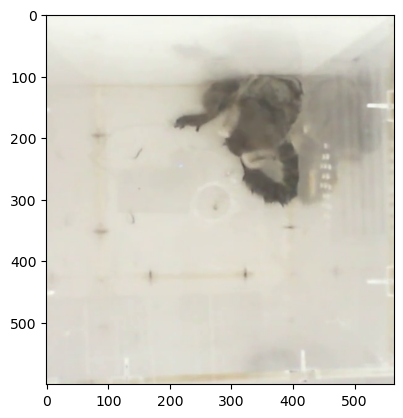

In [10]:
cap = cv2.VideoCapture(video_path) 
numOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
chosenFrameIdx = np.random.randint(1, high=numOfFrames)
cap.set(cv2.CAP_PROP_POS_FRAMES, chosenFrameIdx)
res, chosenFrame = cap.read()

original_height, original_width, _ = chosenFrame.shape
display_max_width = 700
ratio = display_max_width / original_width
display_height = int(original_height * ratio)

frame_for_selection = cv2.resize(chosenFrame, (display_max_width, display_height))

roi_small = cv2.selectROI('Select the arena, then press space and enter', frame_for_selection) 

x_scale = original_width / display_max_width
y_scale = original_height / display_height

roi_original_scale = (
    int(roi_small[0] * x_scale),
    int(roi_small[1] * y_scale),
    int(roi_small[2] * x_scale),
    int(roi_small[3] * y_scale)
)

roi_cropped = chosenFrame[int(roi_original_scale[1]):int(roi_original_scale[1]+roi_original_scale[3]), int(roi_original_scale[0]):int(roi_original_scale[0]+roi_original_scale[2])]
plt.imshow(cv2.cvtColor(roi_cropped, cv2.COLOR_BGR2RGB))
plt.show()

cv2.waitKey(0) 
cv2.destroyAllWindows()

arenaSide = (roi_original_scale[2] + roi_original_scale[3]) / 2 
xThresholdLeft = roi_original_scale[0]
xThresholdRight = roi_original_scale[0] + arenaSide
yThresholdUp = roi_original_scale[1]
yThresholdDown = roi_original_scale[1] + arenaSide

##### Select stim area

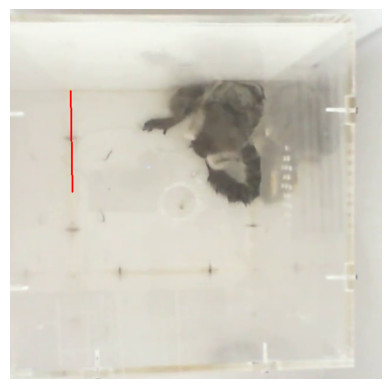

In [55]:
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, chosenFrameIdx)
res, chosenFrame = cap.read()

original_height, original_width, _ = chosenFrame.shape
display_max_width = 700
ratio = display_max_width / original_width
display_height = int(original_height * ratio)

frame_for_selection = cv2.resize(chosenFrame, (display_max_width, display_height))

x1, y1, x2, y2 = cv2.selectROI('Selecione a linha (clique e arraste)', frame_for_selection, fromCenter=False, showCrosshair=True)
cv2.destroyAllWindows()

x_scale = original_width / display_max_width
y_scale = original_height / display_height

pt1 = (int(x1 * x_scale), int(y1 * y_scale))
pt2 = (int((x1 + x2) * x_scale), int((y1 + y2) * y_scale))

frame_with_line = chosenFrame.copy()
cv2.line(frame_with_line, pt1, pt2, (0, 0, 255), 2)
plt.imshow(cv2.cvtColor(frame_with_line, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


### Convert pixel to cm

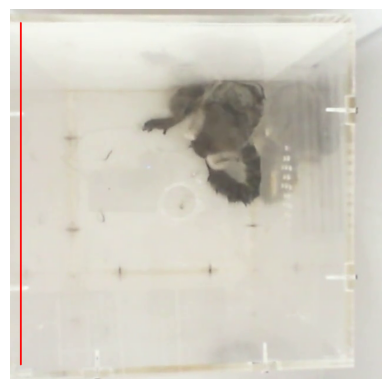

Pixels per cm: 22.384615384615383


In [56]:
py1 = yThresholdDown 
py2 = yThresholdUp
px = xThresholdLeft

frame_with_line = chosenFrame.copy()
cv2.line(frame_with_line, (px, int(py1)), (px, int(py2)), (0, 0, 255), 2)  
frame_with_line_rgb = cv2.cvtColor(frame_with_line, cv2.COLOR_BGR2RGB)
plt.imshow(frame_with_line_rgb)
plt.axis('off') 
plt.show()

pix_per_cm = (py1-py2) / 26 # 26 cm é a distância entre os dois pontos
print(f"Pixels per cm: {pix_per_cm}")

### Filter coordinates

In [65]:
body_x = df[('body', 'x')].values
body_y = df[('body', 'y')].values
head_x = df[('head', 'x')].values
head_y = df[('head', 'y')].values
nose_x = df[('nose', 'x')].values
nose_y = df[('nose', 'y')].values

body_x_filt = np.where((body_x >= xThresholdLeft) & (body_x <= xThresholdRight), body_x, np.nan)    
body_y_filt = np.where((body_y >= yThresholdUp) & (body_y <= yThresholdDown), body_y, np.nan)
head_x_filt = np.where((head_x >= xThresholdLeft) & (head_x <= xThresholdRight), head_x, np.nan)
head_y_filt = np.where((head_y >= yThresholdUp) & (head_y <= yThresholdDown), head_y, np.nan)
nose_x_filt = np.where((nose_x >= xThresholdLeft) & (nose_x <= xThresholdRight), nose_x, np.nan)
nose_y_filt = np.where((nose_y >= yThresholdUp) & (nose_y <= yThresholdDown), nose_y, np.nan)

body_x_cm = body_x_filt / pix_per_cm
body_y_cm = body_y_filt / pix_per_cm
head_x_cm = head_x_filt  / pix_per_cm
head_y_cm = head_y_filt  / pix_per_cm
nose_x_cm = nose_x_filt  / pix_per_cm
nose_y_cm = nose_y_filt  / pix_per_cm
pt1x = pt1[0]/pix_per_cm
pt1y = pt1[1]/pix_per_cm
pt2x = pt2[0]/pix_per_cm
pt2y = pt2[1]/pix_per_cm


mask_combined = (
    ~np.isnan(body_x_cm) & 
    ~np.isnan(body_y_cm) &
    ~np.isnan(head_x_cm) & 
    ~np.isnan(head_y_cm) &
    ~np.isnan(nose_x_cm) & 
    ~np.isnan(nose_y_cm)
)

body_x = body_x_cm[mask_combined]
body_y = body_y_cm[mask_combined]
head_x = head_x_cm[mask_combined]
head_y = head_y_cm[mask_combined]
nose_x = nose_x_cm[mask_combined]
nose_y = nose_y_cm[mask_combined]

body_x = pd.Series(body_x).rolling(window=59, min_periods=1, center=True).mean().values
body_y = pd.Series(body_y).rolling(window=59, min_periods=1, center=True).mean().values
head_x = pd.Series(head_x).rolling(window=59, min_periods=1, center=True).mean().values
head_y = pd.Series(head_y).rolling(window=59, min_periods=1, center=True).mean().values
nose_x = pd.Series(nose_x).rolling(window=59, min_periods=1, center=True).mean().values
nose_y = pd.Series(nose_y).rolling(window=59, min_periods=1, center=True).mean().values

### Polar plot config

In [58]:
dx = nose_x - head_x
dy = nose_y - head_y
fps = 30

angles_rad = np.arctan2(dy, dx)
angles_deg = (np.degrees(angles_rad) + 360) % 360

bin_size = 20 
bins = np.arange(0, 361, bin_size)
counts, bin_edges = np.histogram(angles_deg, bins=bins)
bin_centers_deg = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
theta = np.deg2rad(bin_centers_deg)

radii = counts/fps
width = np.deg2rad(bin_size)
colors = plt.cm.viridis(radii / np.max(radii))

### Plot and save

In [59]:
figures_to_save = {}

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
animal_name = 'Fiona'
condition = 'aversive'

filename1 = f'histograma_{animal_name}_{condition}_{timestamp}.png'
filename2 = f'heatmap_{animal_name}_{condition}_{timestamp}.png'
filename3 = f'tracking_{animal_name}_{condition}_{timestamp}.png'
filename4 = f'polar_{animal_name}_{condition}_{timestamp}.png'
filename5 = f'direction_{animal_name}_{condition}_{timestamp}.png'

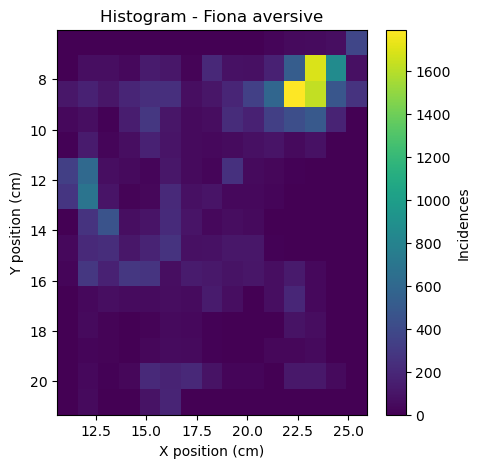

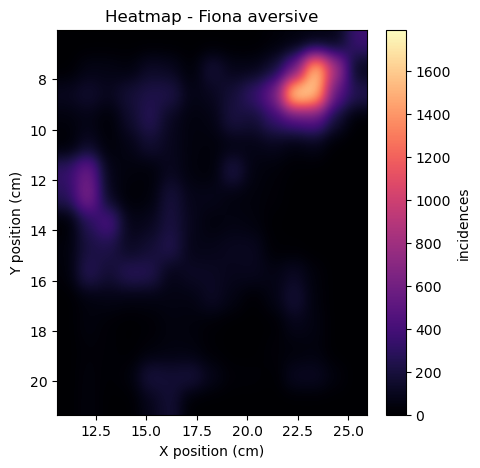

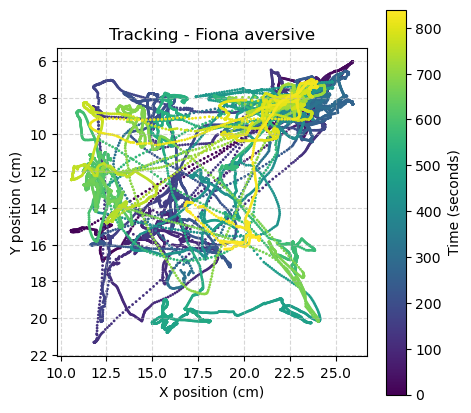

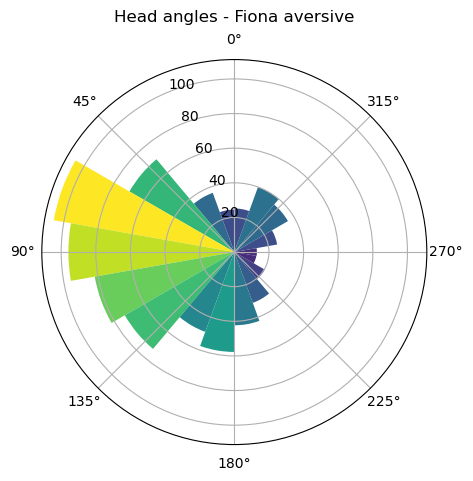

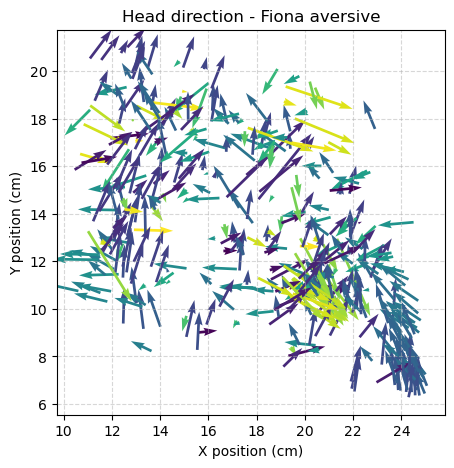

In [60]:
fps = 30

fig1, ax1 = plt.subplots(figsize=(5, 5))
mappable = ax1.hist2d(body_x, body_y, bins=15)[3]
ax1.set_title('Histogram - ' + animal_name +' '+ condition)
ax1.set_xlabel('X position (cm)')
ax1.set_ylabel('Y position (cm)')
fig1.colorbar(mappable, ax=ax1, label='Incidences')
ax1.invert_yaxis()
figures_to_save[filename1] = fig1

fig2, ax2 = plt.subplots(figsize=(5, 5))
h, xedges, yedges = np.histogram2d(body_x, body_y, bins=15)
im = ax2.imshow(h.T, origin='lower', cmap='magma',
               interpolation='gaussian',
               extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
               aspect='auto', vmin=0, vmax=np.max(h))
fig2.colorbar(im, ax=ax2, label='incidences', orientation='vertical', shrink=1.0)
ax2.set_title('Heatmap - ' + animal_name +' '+ condition)
ax2.set_xlabel('X position (cm)')
ax2.set_ylabel('Y position (cm)')
ax2.invert_yaxis()
figures_to_save[filename2] = fig2

fig3, ax3 = plt.subplots(figsize=(5, 5))
time = np.arange(len(body_x))/fps
scatter = ax3.scatter(body_x, body_y, c=time, s=1, cmap='viridis')
fig3.colorbar(scatter, ax=ax3, label='Time (seconds)')
ax3.set_title('Tracking - ' + animal_name +' '+ condition)
ax3.grid(True, linestyle='--', alpha=0.5)
ax3.set_xlabel('X position (cm)')
ax3.set_ylabel('Y position (cm)')
ax3.set_aspect('equal', adjustable='box')
ax3.invert_yaxis()
figures_to_save[filename3] = fig3

fig4, ax4 = plt.subplots(figsize=(5, 5), subplot_kw={'projection': 'polar'})
ax4.bar(theta, radii, width=width, bottom=0.0, color=colors)
ax4.set_theta_zero_location('N')  
ax4.set_theta_direction(1)     
ax4.set_title('Head angles - ' + animal_name +' '+ condition, va='bottom')
plt.show()
figures_to_save[filename4] = fig4

fig5, ax5 = plt.subplots(figsize=(5, 5))
f = 60
ax5.quiver(head_x[::f], head_y[::f],
           dx[::f], dy[::f],
           angles_deg[::f], scale=20, cmap='viridis', width=0.007)
ax5.set_title('Head direction - ' + animal_name +' '+ condition)
ax5.set_xlabel('X position (cm)')
ax5.set_ylabel('Y position (cm)')
ax5.grid(True, linestyle='--', alpha=0.5)
plt.show()
figures_to_save[filename5] = fig5

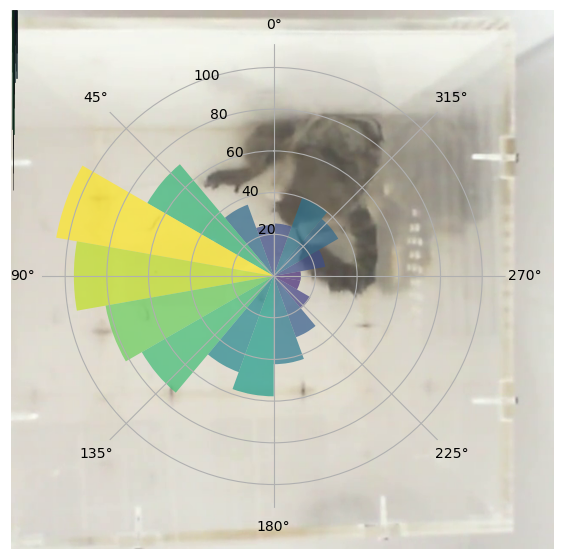

In [61]:
# Selecionar um frame do vídeo (por exemplo, o mesmo usado para seleção da arena)
cap.set(cv2.CAP_PROP_POS_FRAMES, chosenFrameIdx)
_, frame = cap.read()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(frame_rgb)
ax.axis('off')

# Coordenadas do centro do plot polar (em pixels)
center_x = int(original_width // 2)
center_y = int(original_height // 2)

# Definir raio máximo para o plot polar (em pixels)
max_radius = min(original_width, original_height) // 3

# Normalizar radii para caber no raio máximo
radii_norm = radii / np.max(radii) * max_radius

# Plotar barras polares sobre a imagem
for th, r, c in zip(theta, radii_norm, colors):
    ax.bar(
        th, r, width=width, bottom=0.0,
        color=c, alpha=0.7,
        edgecolor='k',
        linewidth=0.5
    )

# Ajustar o plot polar para o centro da imagem
polar_ax = fig.add_axes([0, 0, 1, 1], polar=True, frameon=False)
polar_ax.set_position([
    (center_x - max_radius) / original_width,
    (center_y - max_radius) / original_height,
    2 * max_radius / original_width,
    2 * max_radius / original_height
])
polar_ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.7)
polar_ax.set_theta_zero_location('N')
polar_ax.set_theta_direction(1)

plt.show()

In [71]:
def find_gaze_intersection(head_point, nose_point, line_p1, line_p2):
    """
    Calcula a interseção entre o raio da visão (cabeça->nariz) e um segmento de linha.
    Retorna True se a interseção for válida, caso contrário, False.
    """
    h_x, h_y = head_point
    n_x, n_y = nose_point
    l1_x, l1_y = line_p1
    l2_x, l2_y = line_p2

    gaze_dx = n_x - h_x
    gaze_dy = n_y - h_y
    line_dx = l2_x - l1_x
    line_dy = l2_y - l1_y

    determinant = gaze_dx * line_dy - gaze_dy * line_dx

    # Se as linhas são paralelas, não há interseção.
    if determinant == 0:
        return False

    # --- FÓRMULA CORRIGIDA PARA 'u' ---
    # Calcula 't' (distância ao longo do raio da visão)
    t = ((l1_x - h_x) * line_dy - (l1_y - h_y) * line_dx) / determinant
    # --- LÓGICA DE VERIFICAÇÃO UNIFICADA E CORRIGIDA ---
    # Retorna True apenas se AMBAS as condições forem satisfeitas.
    if t >= 0:
        return True
    else:
        return False

# --- DADOS DE EXEMPLO ---

# --- LOOP PRINCIPAL AJUSTADO ---
crossings = []

# Itera sobre os arrays de trajetória já filtrados e suavizados
for i in range(len(head_x)):
    head_pt = (head_x[i], head_y[i])
    nose_pt = (nose_x[i], nose_y[i])
    
    # A nova função verifica a interseção diretamente
    intersection = find_gaze_intersection(head_pt, nose_pt, (pt1x, pt1y), (pt2x, pt2y))
    
    crossings.append(intersection)

crossings = np.array(crossings)

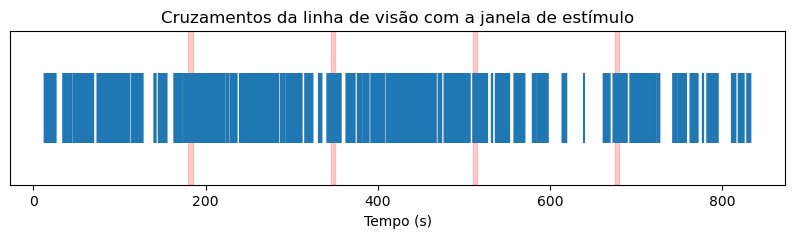

In [72]:
fps = 30.0

plt.figure(figsize=(10, 2))
times = np.arange(len(crossings)) / fps
plt.eventplot(times[crossings == 1], orientation='horizontal')
plt.xlabel('Tempo (s)')
plt.yticks([])
for _, row in stim_df.iterrows():
    plt.axvspan(row['stim_ON'], row['stim_OFF'], color='red', alpha=0.2)
plt.title('Cruzamentos da linha de visão com a janela de estímulo')
plt.show()


4.601374570446736

In [25]:
folder_name = animal_name +' '+ condition
os.makedirs(folder_name, exist_ok=True)

for filename, fig_object in figures_to_save.items():
        full_path = os.path.join(folder_name, filename)

        fig_object.savefig(full_path, dpi=300, bbox_inches='tight')
        print(f"- Figura '{filename}' salva com sucesso.")

- Figura 'histograma_Fiona_aversive_2025-08-08_10-39.png' salva com sucesso.
- Figura 'heatmap_Fiona_aversive_2025-08-08_10-39.png' salva com sucesso.
- Figura 'tracking_Fiona_aversive_2025-08-08_10-39.png' salva com sucesso.
- Figura 'polar_Fiona_aversive_2025-08-08_10-39.png' salva com sucesso.
- Figura 'direction_Fiona_aversive_2025-08-08_10-39.png' salva com sucesso.
